Title: Kitty Got Claws! A Comparison of CatBoost and XGBoost
Date: 2019-04-23 10:20
Tags: python
Slug: blog_3

Boosting is an ensemble technique where new models are created to correct the errors of past models. Each subsequent tree learns from the errors of its predecessor, as all trees are added sequentially until no further improvements can be made. Gradient boosting is an approach where new models are created from the residuals or errors of prior models and then are added together to make the final prediction. The base learners in gradient boosting are weak learners, but each contributes vital information for the final model. Two examples of these programs are XGBoost and CatBoost. They are two open-source software libraries that provide a gradient boosting framework. 

To compare these two programs, I will load a dataset called "Skyserver", and I will attempt to predict whether an image is a Star, Galaxy, or Quasar. I will begin with XGBoost.

In [5]:
import pandas as pd 
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper, FunctionTransformer
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.metrics import mean_squared_error

import catboost as cb
from catboost import CatBoostClassifier, cv, Pool
import shap

import xgboost as xgb
from xgboost import plot_tree, XGBClassifier, plot_importance


sky = pd.read_csv('Skyserver.csv')

The first thing I do with a dataset is some basic EDA. This includes checking to see whether there are null values: sky.isnull().sum(). The Skyserver dataset is very clean and there are no null values. However, with XGBoost, even if there were null values, XGBoost has a built in algorithm to impute these missing values. Its algorithm automatically learns what is the best imputation value for missing values based on training. This is one key advantage of using XGBoost. 

Before I am ready to model, I will prepare my dataset, by labeling the 3 items in the target column - 'star', 'galaxy', 'qso'. Then I will drop unnecessary columns, and assign my y(target) and X(features).

In [6]:
sky['class'] = sky['class'].map({'STAR': 0, 'GALAXY': 1, 'QSO': 2})

In [7]:
sky = sky.drop(columns=['objid', 'rerun', 'mjd']) 
#drop 'objid' because irrelevant to model and 'rerun' because it has the same value for each row.

In [8]:
y = sky['class']
X = sky.drop('class', axis=1)

In [9]:
data_dmatrix = xgb.DMatrix(data=X, label=y) 
#DMatrix is an internal data structure used in XGBoost. It is recommended as it is optimal for memory and speed.

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Having completed basic EDA, assigned our X and y, and created a data dmatrix, we are ready to split out data into training and testing sets and use DataFrameMapper, StandardScaler and LabelBinarizer to prepare our data. We do not need to worry about imputing at this point, because as stated above, in addition to the dataset being clean of missing values, XGBoost has a built in imputer that deals with missing values.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Obviously a key difference between XGBoost and CatBoost is how each deals with categorical columns. I'll discuss CatBoost later, but for now, as is shown below, for XGBoost, categorical columns need to be one hot encoded, using LabelBinarizer. Knowing that creating dummy columns, in many instances, could expand datasets to unimaginable sizes, the XGBoost developers introduced a built-in method to deal with this, called Automatic Sparse Data Optimization. The developers chose to handle this in the same way that they handled the existence of missing values, by making the algorithm aware of the sparsity pattern in the dataset. By only visiting the present values, and not the missing values and zeroes; it exploits the sparsity and learns the best directions to handle missing values. It handles all cases of sparsity in a unified way. 

In [ ]:
mapper = DataFrameMapper([
    (['ra'], StandardScaler()),
    (['dec'], StandardScaler()),
    (['u'], StandardScaler()),
    (['g'], StandardScaler()),
    (['r'], StandardScaler()),
    (['i'], StandardScaler()),
    (['z'], StandardScaler()),
    (['run'], StandardScaler()),
    ('camcol', LabelBinarizer()),
    ('field', LabelBinarizer()),
    (['specobjid'], StandardScaler()),
    (['redshift'], StandardScaler()),
    ('plate', LabelBinarizer()),
    ('fiberid', LabelBinarizer()),
], default=None, df_out=True)

Z_train = mapper.fit_transform(X_train)
Z_val = mapper.transform(X_val)

import warnings
warnings.filterwarnings("ignore", category=DataConversionWarning)

Now it's time to model, predict, and score!

In [12]:
model1 = xgb.XGBClassifier(
    n_estimators = 500, #How many trees.
    num_class = 3, #Identifying there are 3 classes in our target
    objective = 'reg:logistic', #Objective refers to which model you want to use.
    eval_set='Accuracy', #Eval_set refers to how you want your model to be evaluated.
    learning_rate=0.1, #Learning_rate has to do with how much you want each tree to learn.
    early_stopping_rounds=10, #stop after ten iterations if no improvements have been made.            
    max_depth=3, #Smaller trees are more interpretable
    silent=False) #Silent deals with whether we want information for each iteration to be printed out.

In [13]:
model1.fit(Z_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, early_stopping_rounds=10, eval_set='Accuracy',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, num_class=3, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=False, subsample=1)

In [14]:
preds = model1.predict(Z_val)

In [15]:
mean_squared_error(y_val, preds)

0.01

Another key feature is that there is a built-in cross validation. This runs a cross validation at each iteration of the boosting process.

In [16]:
params = {'colsample_bytree': '0.3', #the fraction of columns to be randomly sampled for each tree.
        'learning_rate': '0.2', 
        'max_depth': '5', #the maximum depth of a tree
        'alpha': '10'} #L1 regularization weight - Lasso

cross_val_results = xgb.cv(dtrain=data_dmatrix, params=params) #this is where the dmatrix comes in handy.

In [17]:
cross_val_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.615842,0.001887,0.617878,0.001618
1,0.514400,0.023372,0.517281,0.024252
2,0.456278,0.013461,0.460037,0.015424
3,0.420923,0.006550,0.426109,0.009830
4,0.385381,0.030245,0.391525,0.033427


In [18]:
print((cross_val_results["test-rmse-mean"]).tail(1))

9    0.281167
Name: test-rmse-mean, dtype: float64


In [19]:
xgreg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=15)

A benefit of using boosting is that it provides you with feature importance. It provides you with a score which indicates how valuable a feature was in the construction of the boosted decision tree. The more a certain feature is used to make key decisions in the decision tree, the higher its importance. Importance is calculated by the the amount that each split point improves the overall tree, weighted over the number of observations it is resposible for.



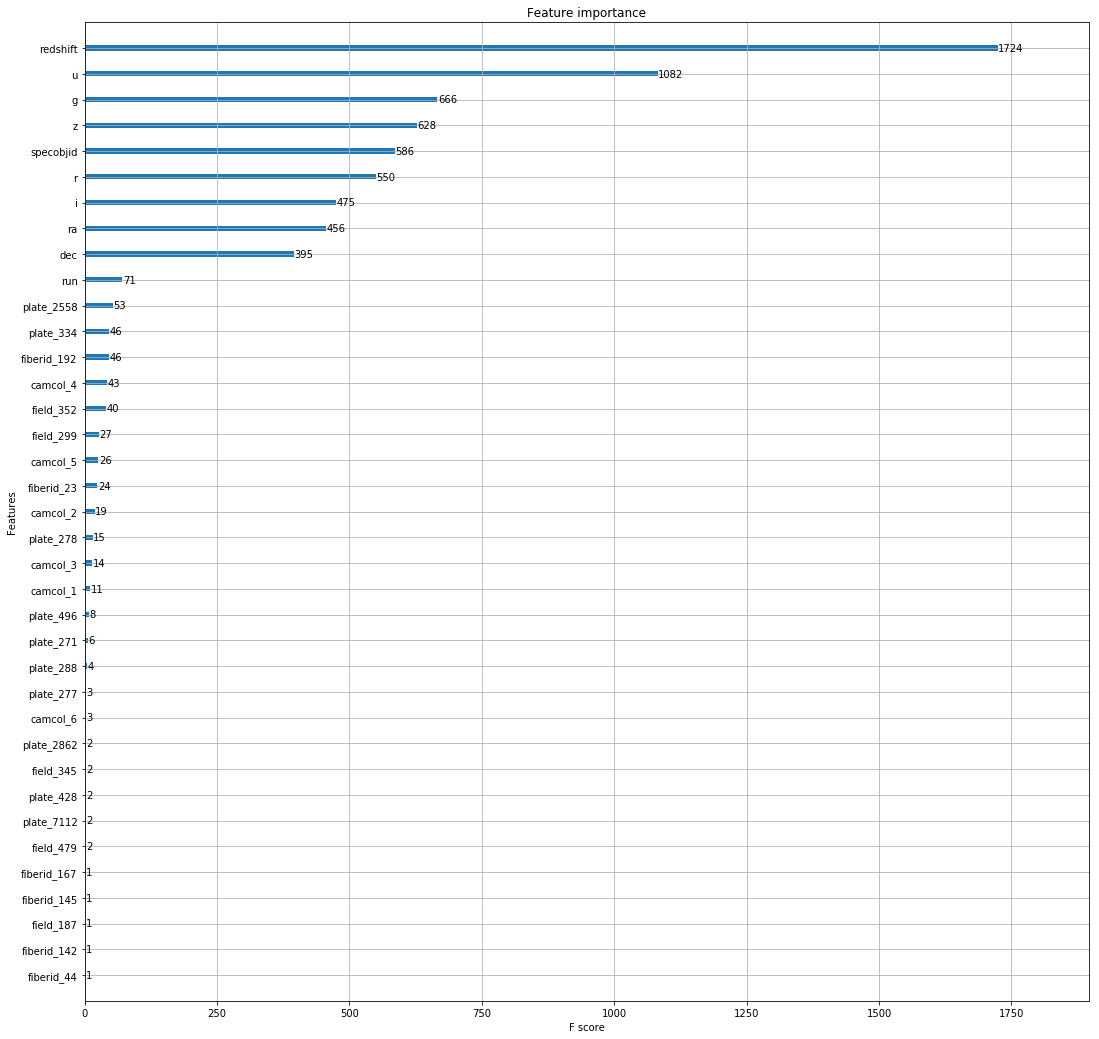

In [20]:
fig, ax = plt.subplots(figsize=(18, 18))
plot_importance(model1, ax=ax)
plt.show()

As can be viewed by the chart, Redshift is by the far the most important feature.

XGBoost also provides the ability to peak into your model and inspect a tree. 

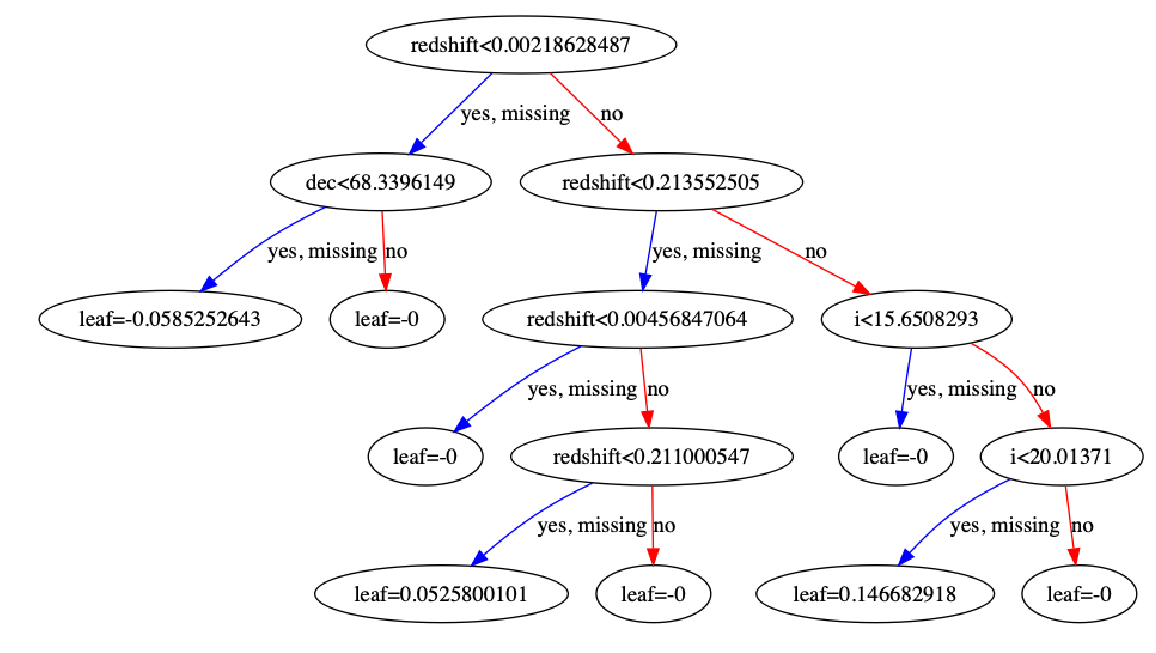

In [21]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_tree(xgreg, num_trees=4, ax=ax)
plt.show()

Above you can see how a decision tree on this data looks. You can see that it is assymetrical, which is an important point of comparison with CatBoost's trees. One interesting aspect about this tree is the fact that you can see that the algorithm has chosen to impute all 'missing' values with the direction of yes. 

According to XGBoost's documentation, website, and papers given by founder, Tianqi Chen, in addition to the features described above, XGBoost's power also comes from its 'Block structures for parallel learning', 'Cache Awareness', and 'Out of Core Computing'. Data is sorted and stored in memory units called blocks. This allows the data to easily be re-used in later iterations, instead of the data having to be computed again. The data in each block is stored in a compressed column format, and with one scan of the block, the statistics for the split candidates can be found. Cache awareness is the existence of internal buffers where gradient stats can be stored. Out of core computing allows optimized disk space and maximized usage when dealing with datasets that are too large to fit in memory.
    
The one area where XGBoost is lacking is in feature engineering and hyper-parameter tuning. Chen, and the XGBoost team however, believe this is fine, as these areas are deeply integrated within coding programs. After reading documentation and several data science blogs on boosting systems, I see that there is an ability to grid search to find the best parameters. However, considering these boosting frameworks are designed for extremely large datasets, if we were to grid search one of these files, it would be computationally expensive, and time consuming. (Running a basic cross-validation ran almost 15 minutes). In order to improve a model, hyper-tuning is necessary, but it's hard to determine which parameters should be tuned and what the ideal value of each should be. 

# Catboost

CatBoost is another open-source gradient boosting on decision trees library. CatBoost's claim to fame is its categorical feature support. Instead of having to take care of one-hot-encoding during pre-processing the data, the CatBoost algorithm handles categorical columns while training the data. 

I'm now going to use DataFrameMapper and StandardScaler to prepare the rest of the data. Following this, I will pass the categorical features, while fitting the model.

In [33]:
mapper2 = DataFrameMapper([
    (['ra'], StandardScaler()),
    (['dec'], StandardScaler()),
    (['u'], StandardScaler()),
    (['g'], StandardScaler()),
    (['r'], StandardScaler()),
    (['i'], StandardScaler()),
    (['z'], StandardScaler()),
    (['run'], StandardScaler()),
    (['specobjid'], StandardScaler()),
    (['redshift'], StandardScaler()),
], default=None, df_out=True)

Z_train2 = mapper2.fit_transform(X_train)
Z_val2 = mapper2.transform(X_val)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [34]:
# categorical_features = list(range(0, X.shape[1]))
categorical_features = np.where(Z_train2.dtypes == int)[0]

In [35]:
print(categorical_features)

[10 11 12 13]


In [36]:
model2 = CatBoostClassifier(
    iterations=100,
    learning_rate=0.5,
    early_stopping_rounds = 10,
    loss_function = 'MultiClass', #For 2-class classification, we should use "Logloss" or "Entropy"
    custom_metric='AUC',
    use_best_model=True,
    verbose=5 #information is printed out at every fifth iteration
)
model2.fit(
    Z_train2, y_train,
    cat_features=categorical_features,
    eval_set=(Z_val2, y_val),
    plot=False #This should be True. But the printout is not compatible with this blog framework
)

0:	learn: -0.4231271	test: -0.4268821	best: -0.4268821 (0)	total: 108ms	remaining: 10.7s
5:	learn: -0.0695255	test: -0.0717988	best: -0.0717988 (5)	total: 447ms	remaining: 7s
10:	learn: -0.0461552	test: -0.0538007	best: -0.0538007 (10)	total: 947ms	remaining: 7.67s
15:	learn: -0.0407958	test: -0.0510322	best: -0.0508512 (14)	total: 1.46s	remaining: 7.68s
20:	learn: -0.0350664	test: -0.0461989	best: -0.0461989 (20)	total: 1.99s	remaining: 7.48s
25:	learn: -0.0315475	test: -0.0459406	best: -0.0459406 (25)	total: 2.47s	remaining: 7.03s
30:	learn: -0.0272609	test: -0.0449078	best: -0.0449078 (30)	total: 2.96s	remaining: 6.6s
35:	learn: -0.0247762	test: -0.0422198	best: -0.0421584 (34)	total: 3.52s	remaining: 6.26s
40:	learn: -0.0233293	test: -0.0422688	best: -0.0421584 (34)	total: 4.09s	remaining: 5.88s
Stopped by overfitting detector  (10 iterations wait)

bestTest = -0.04215835272
bestIteration = 34

Shrink model to first 35 iterations.


<img src='images/newplot1.png' alt='newplot1'>

A great feature of CatBoost is it provides information at points specified in your params (above was 'verbose = 5').

In [37]:
model2.tree_count_

35

In [38]:
model2.predict_proba
print(model2.predict_proba(data=Z_val2))

[[4.01704757e-04 9.80671060e-01 1.89272355e-02]
 [3.08763482e-04 9.96511522e-01 3.17971463e-03]
 [3.89049775e-04 9.98622853e-01 9.88097567e-04]
 ...
 [9.97135061e-01 2.57287349e-03 2.92065282e-04]
 [9.96680305e-01 2.99639694e-03 3.23297602e-04]
 [2.87351792e-04 9.95101706e-01 4.61094214e-03]]


In [39]:
predictions2 = model2.predict(data=Z_val2)

Like XGBoost, CatBoost also includes an early stopping round. In my model, I set this parameter to 10. This means that if no improvement has been made after 10 trees, the model will stop running. This helps prevent against over fitting. CatBoost also, like XGBoost, has a built in cross-validation.

In [42]:
params = {'loss_function': 'MultiClass',
          'custom_loss': 'AUC'
         }

cross_val_results2 = cv(
            params = params,
            pool = Pool(Z_train2, y_train, cat_features=categorical_features),
            fold_count = 5, #number of folds to split the data into.
            inverted = False,
            shuffle = True, #data is randomly shuffled before splitting.
            partition_random_seed = 0,
            stratified = False,
            verbose = False)


In [43]:
cross_val_results2.head()

,iterations,test-MultiClass-mean,test-MultiClass-std,train-MultiClass-mean,train-MultiClass-std,test-AUC:class=0-mean,test-AUC:class=0-std,test-AUC:class=1-mean,test-AUC:class=1-std,test-AUC:class=2-mean,test-AUC:class=2-std
0,0,-1.042713,0.000341,-1.042747,0.000093,0.992025,0.003681,0.985580,0.003899,0.982720,0.005111
1,1,-0.992463,0.001261,-0.992504,0.001639,0.997906,0.001791,0.992262,0.002721,0.984138,0.005245
2,2,-0.946050,0.000323,-0.945929,0.000795,0.997925,0.001205,0.993606,0.002700,0.988726,0.003737
3,3,-0.903349,0.000100,-0.903072,0.000699,0.998220,0.001502,0.993857,0.003076,0.988547,0.003624
4,4,-0.863164,0.000607,-0.863020,0.000325,0.998217,0.001357,0.994078,0.002699,0.988690,0.003612


Also similar to XGBoost, CatBoost provides the user with feature importance. By calling on 'get_feature_importance', the user can see what the model learned about the features and which of them have the greatest influence on the decisions trees.

In [44]:
fstrs = model2.get_feature_importance(prettified=True)

In [45]:
{feature_name : value for  feature_name, value in fstrs}

{'redshift': 78.69840467429411,
 'i': 8.742787892612705,
 'u': 3.487814704869871,
 'specobjid': 2.0436652601559193,
 'plate': 1.8955707345778037,
 'z': 1.42498154722369,
 'field': 0.9011905403991105,
 'run': 0.7856686087514119,
 'fiberid': 0.48419622387041755,
 'dec': 0.40877000998928603,
 'g': 0.3113040809109803,
 'ra': 0.3112717293491661,
 'r': 0.25950045766926433,
 'camcol': 0.24487353532627085}

While XGBoost had the ability to use matplotlib to plot, Catboost's equivalent is brought to us by shap.

In [46]:
explainer = shap.TreeExplainer(model2)
shap_values = explainer.shap_values(Pool(Z_train2, y_train, cat_features=categorical_features))

/anaconda3/lib/python3.6/site-packages/catboost/core.py:1697: UserWarning: 'fstr_type' parameter will be deprecated soon, use 'type' parameter instead
  warnings.warn("'fstr_type' parameter will be deprecated soon, use 'type' parameter instead")
The model has complex ctrs, so the SHAP values will be calculated approximately.


In [47]:
explainer.expected_value

[0.10654885020023455, 1.5818176696303439, -1.6883665198535525]

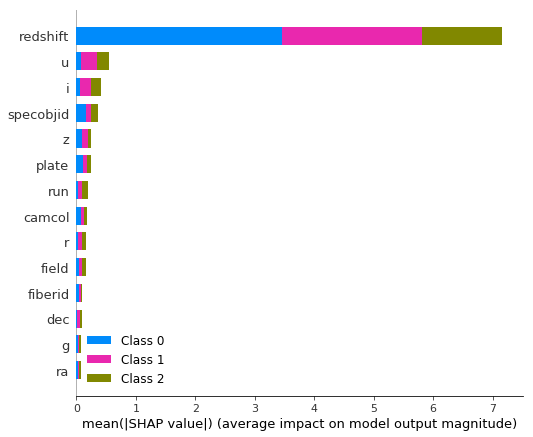

In [48]:
shap.summary_plot(shap_values, Z_train2, plot_type="bar")

Above we've done a basic model, and we've discovered that redshift is the value that has the greatest effect on the decision trees. One of the best features about CatBoost is that we can now fine-tune parameters in order to speed up the model.

In [49]:
fast_model = CatBoostClassifier(
    random_seed=62,
    iterations=150, #The default is 1000 trees. Lowering the number of trees can speed up the model. 
    learning_rate=0.01, #Typically, if you lower the number of trees, you should raise the learning rate.
    boosting_type='Plain', #The default is Ordered. This prevents overfitting but is expensive in computation.
    bootstrap_type='Bernoulli', #The default is Bayesian. Bernoulli is faster.
    subsample=0.5, #less than 1 is optimal for speed.
    rsm=0.5, #random subspace method speeds up the training
    leaf_estimation_iterations=5, #for smaller datasets this should be set at 1 or 5.
    max_ctr_complexity=1)
#We could also set one_hot_max_size to larger than the default 2. The default 2 means that any category that has 2 
#or less values will be hot encoded. The rest will be computated by catboosts algorithm. This is more computationally
#expensive.
fast_model.fit(
    Z_train2, y_train,
    cat_features=categorical_features,
    verbose=False,
    plot=False
)

<img src='images/newplot2.png' alt='newplot2'>

In addition to the above parameters that were adjusted to speed up the model's performance, there are also more parameters that can be used to fine-tune the model.

In [50]:
tuned_model = CatBoostClassifier(
    iterations=500,
    depth = 6, # how deep trees will go. Usually best between 1 and 10
    learning_rate=0.03,
    l2_leaf_reg=3, #regularizer value for Ridge regression
    bagging_temperature=1,
    one_hot_max_size=2, #2 is the default value. 
    leaf_estimation_method='Newton',
    loss_function='MultiClass'
)
tuned_model.fit(
    Z_train2, y_train,
    cat_features=categorical_features,
    verbose=False,
    eval_set=(Z_val2, y_val),
    plot=False
)

<img src='images/newplot3.png' alt='newplot3'>

In [51]:
final_model = CatBoostClassifier(
    random_seed=63,
    iterations=int(tuned_model.tree_count_),
)
final_model.fit(
    Z_train2, y_train,
    cat_features=categorical_features,
    verbose=100
)

Learning rate set to 0.055965
0:	learn: 0.5431275	total: 61.7ms	remaining: 30.8s
100:	learn: 0.0057702	total: 6.14s	remaining: 24.3s
200:	learn: 0.0032198	total: 11.3s	remaining: 16.8s
300:	learn: 0.0021840	total: 16.3s	remaining: 10.8s
400:	learn: 0.0016674	total: 21.1s	remaining: 5.21s
499:	learn: 0.0013561	total: 25.5s	remaining: 0us


In [52]:
print(final_model.get_best_score())

{'learn': {'Logloss': 0.0013560782767138484}}


The greatest benefit of CatBoost is its ability to handle categorical features. With other boosting software, we need to preprocess data on our own. This would be done using LabelBinarizer (as shown above in the XGBoost section). Although DataFrameMapper makes this task more manageable, in some cases it may lead to datasets that are unimaginably large. In addition to combination features(combining columns), which are converted to number values (these combination features are not used in the first split, but then all will be used in the next splits), CatBoost has a special formula to convert categorical features into numbers. With CatBoost and its categorical features, the data is shuffled and a mean is calculated for every object on its historical data.

ctr i = (countInClass + prior) / (totalCount + 1)

   CountInClass is how many times the label value was equal to i for objects with the current categorical feature value.

   TotalCount is the total number of objects already visited that have the same feature value as the one being visited.

   Prior is a constant defined by the starting parameters
   
   
When it comes to missing values, CatBoost also deals with these during training. The default setting is 'Min' which means that missing values are processed as the minimum value for the feature. It is also guaranteed that a split that seperates all missing values from all other values is considered when selecting trees.

# Conclusion

In addition to categorical features, another main diference between XGBoost and CatBoost is the type of decision trees used. XGBoost uses assymetric trees (which could be viewed above) while CatBoost uses oblivious trees as base predictors. An assymetric tree makes splits that will learn the most. Oblivious trees simply means that the feature used for splitting is the same accross all intermediate nodes within the same level of the tree.


Overall, I find it's hard to choose the best boosting system, because both do a great job and offer great features to work with. This can be viewed by their use in winning Kaggle competition entries. However, I find CatBoost's ability to pass categorical features, instead of one-hot-encoding, novel. It saves time in preparing the data to be modeled and although more computationally expensive at first, I think with larger datasets, where one-hot-encoding could swell the dataset to enormous sizes, it would be more effective. I like the fact that it provides both options when you're fitting a model. The default is 2 - which means that if a categorical column has two or less categories it will hot encode, and if its more than 2, it will run its built-in calculation for categorical columns. Either way, categorical columns are processed internally when training the model. Thus, even if you prefer categorical columns to be one-hot-encoded, you can set the parameters accordingly and not have to pre-process these columns. 

It's hard to choose between the two libraries because I think they both excel with larger datasets than the one I used. However, with my computer and the SkyServer dataset, CatBoost outperformed XGBoost in speed, and I found the ability to fine-tune and speed-up the model more user-friendly and intuitive. Also I found the instant plotting more engaging, and the shap add-on, more visually appealing.